In [1]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder

data_dir = 'Training_Samples'

images = []
labels = []

for file_name in os.listdir(data_dir):
    if file_name.endswith('.png'):
        label = file_name.split(' ')[0] 
        img_path = os.path.join(data_dir, file_name)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize((28, 28))  # Resize to 28x28 pixels
        img = np.array(img)
        
        images.append(img)
        labels.append(label)

images = np.array(images) / 255.0  # Normalize images
labels = np.array(labels)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Reshape images for oversampling (flatten)
X_flattened = images.reshape(images.shape[0], -1)

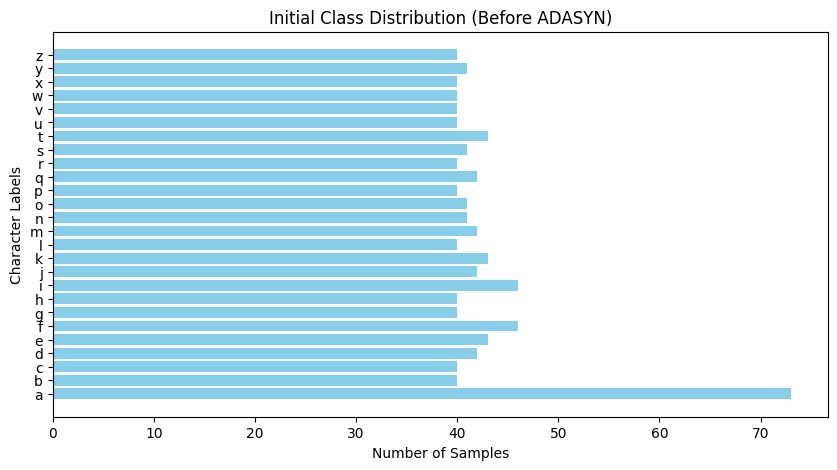

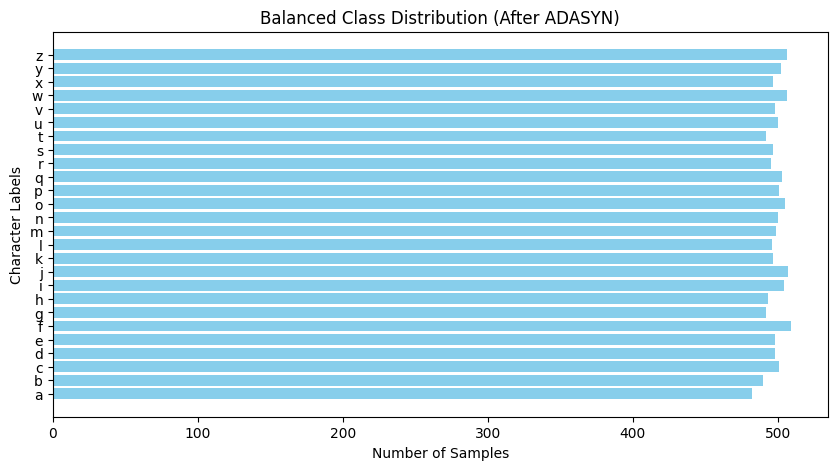

In [3]:
from imblearn.over_sampling import ADASYN
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


desired_samples = 500  # Adjust this based on your data

min_samples_per_class = min(Counter(labels_encoded).values())
adjusted_k = min(min_samples_per_class - 1, 5)  # Ensure k_neighbors is valid

# Use ADASYN with a custom sampling strategy
sampling_strategy = {char: desired_samples for char in Counter(labels_encoded).keys()}

# If all classes already meet or exceed desired_samples, adjust strategy
if min_samples_per_class >= desired_samples:
    print(f"Warning: All classes have at least {desired_samples} samples. Using 'auto' strategy instead.")
    adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=adjusted_k)
else:
    adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=42, n_neighbors=adjusted_k)
X_resampled, y_resampled = adasyn.fit_resample(X_flattened, labels_encoded)

# Reshape back to original format
X_resampled = X_resampled.reshape(-1, 28, 28, 1)

# Convert labels to categorical
y_resampled = to_categorical(y_resampled)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

label_mapping = {i: chr(97 + i) for i in range(26)}  
def plot_class_distribution(labels, title, label_mapping):
    char_counts = Counter(labels)
    sorted_labels = sorted(char_counts.keys())  # Sort labels
    sorted_counts = [char_counts[label] for label in sorted_labels]
    
    original_labels = [label_mapping[label] for label in sorted_labels]

    plt.figure(figsize=(10, 5))
    plt.barh(original_labels, sorted_counts, color='skyblue')
    plt.xlabel("Number of Samples")
    plt.ylabel("Character Labels")
    plt.title(title)
    
    plt.show()

# Plot distributions
plot_class_distribution(labels_encoded, "Initial Class Distribution (Before ADASYN)", label_mapping)
plot_class_distribution(np.argmax(y_resampled, axis=1), "Balanced Class Distribution (After ADASYN)", label_mapping)


In [4]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    BatchNormalization(),

    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN Model with Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_val, y_val),callbacks=[lr_reduction, early_stopping])

model.save('handwritten_alphabet_recognition_model.h5')


C:\Users\91944\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


C:\Users\91944\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.2389 - loss: 3.0762 - val_accuracy: 0.0802 - val_loss: 3.8031 - learning_rate: 0.0010
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5571 - loss: 1.7223 - val_accuracy: 0.7005 - val_loss: 1.2830 - learning_rate: 0.0010
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6774 - loss: 1.3226 - val_accuracy: 0.7537 - val_loss: 1.0276 - learning_rate: 0.0010
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7326 - loss: 1.1326 - val_accuracy: 0.7914 - val_loss: 0.9469 - learning_rate: 0.0010
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7648 - loss: 1.0324 - val_accuracy: 0.6692 - val_loss: 1.2812 - learning_rate: 0.0010
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8021 - loss: 0.9529 - val_accuracy: 0.8547 - val_loss: 0.7331 - learning_rate: 0.0010
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8260 - loss: 0.8616 

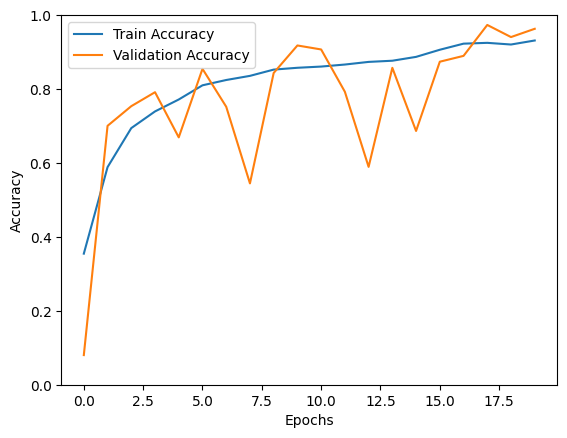

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9700 - loss: 0.3821
Validation accuracy: 97.34%


In [5]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

In [6]:
from sklearn.metrics import classification_report

# Get predictions on validation set
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Generate classification report
class_report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           a       0.98      1.00      0.99       105
           b       0.90      0.99      0.94        93
           c       0.98      0.98      0.98       110
           d       1.00      1.00      1.00        95
           e       0.99      0.90      0.94       108
           f       0.99      0.99      0.99       108
           g       1.00      0.96      0.98        98
           h       1.00      0.95      0.97        95
           i       1.00      0.99      0.99        93
           j       0.98      0.99      0.98        94
           k       0.98      0.98      0.98       106
           l       0.92      0.90      0.91        96
           m       1.00      0.97      0.98        99
           n       0.98      1.00      0.99        87
           o       0.97      0.95      0.96       111
           p       0.98      0.97      0.97        97
           q     

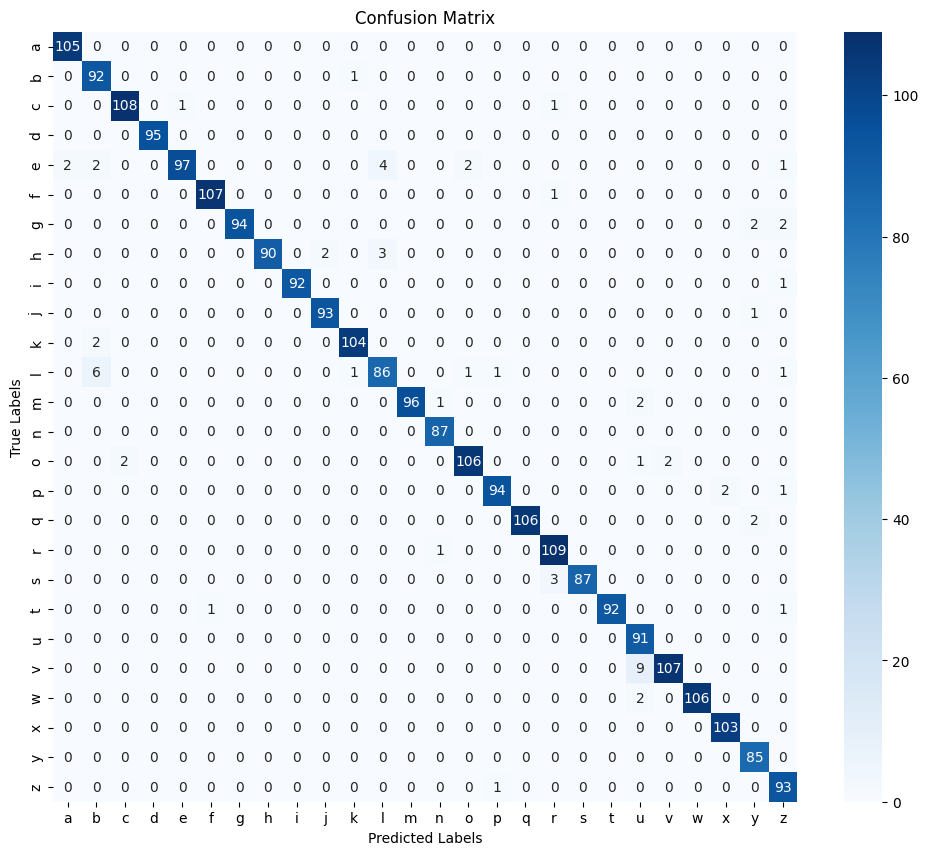

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

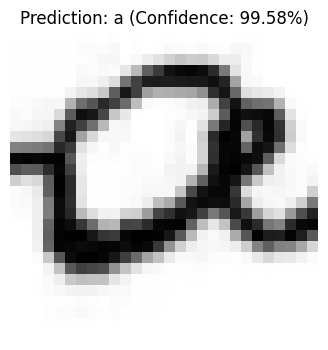

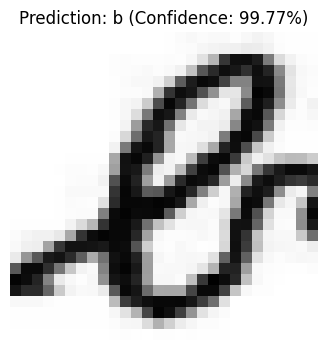

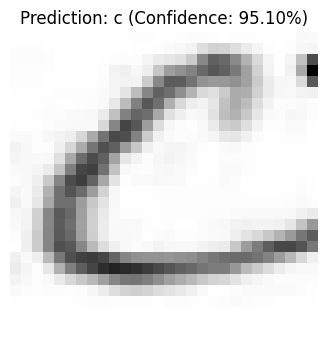

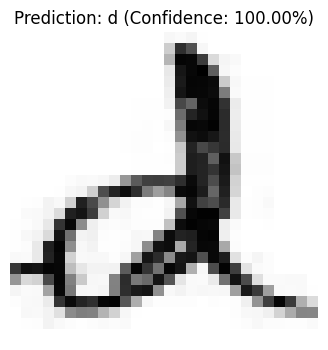

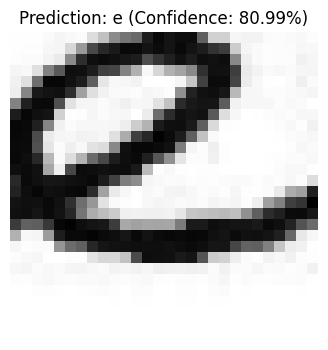

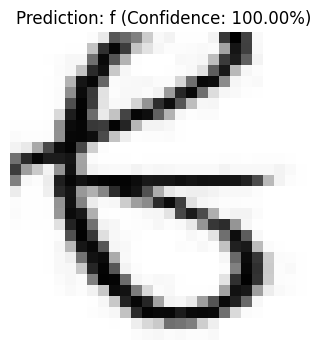

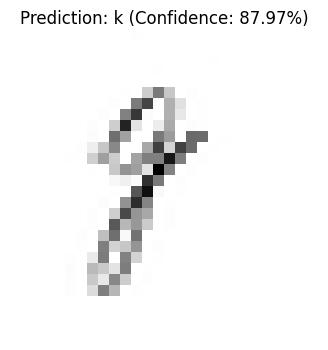

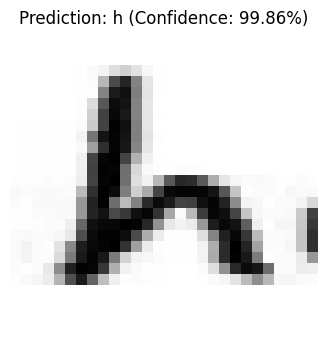

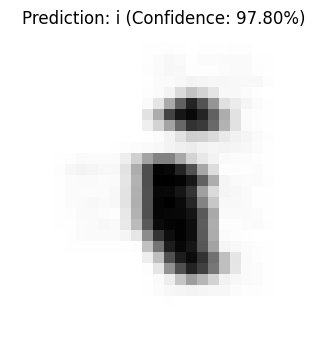

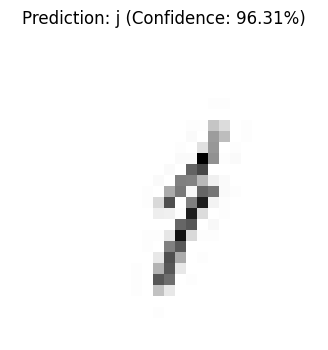

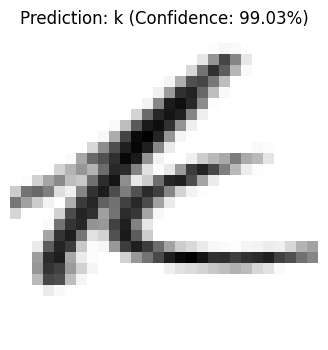

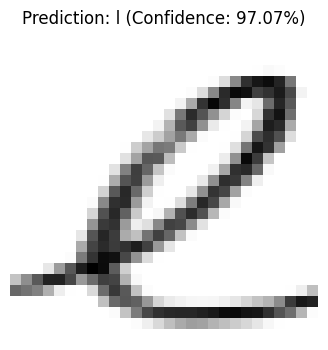

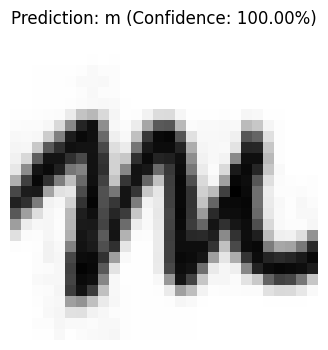

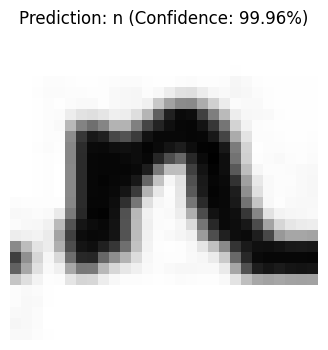

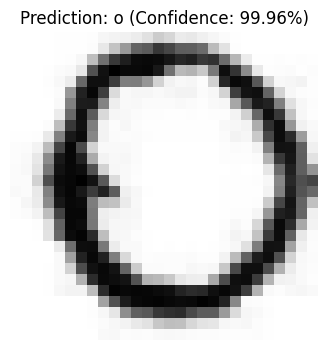

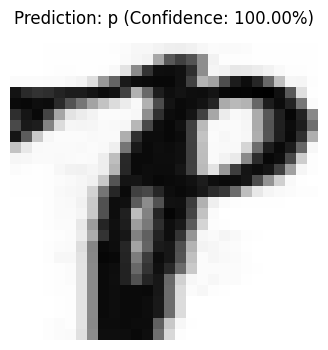

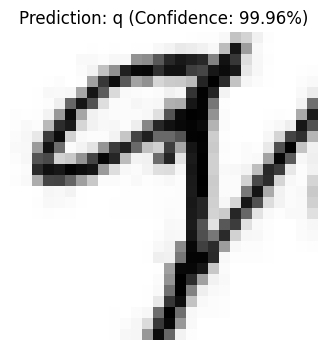

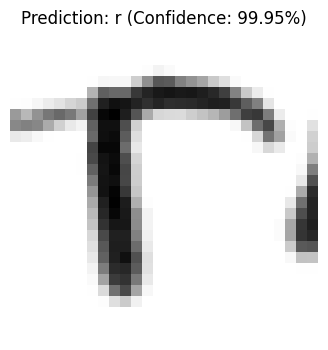

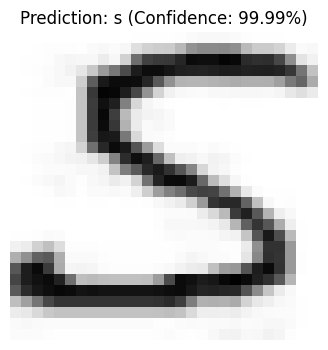

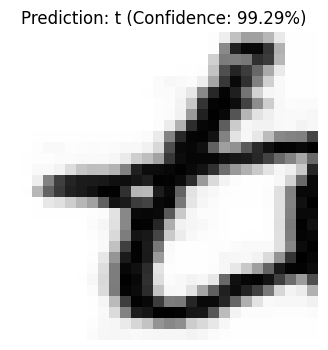

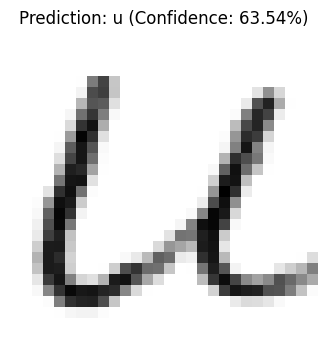

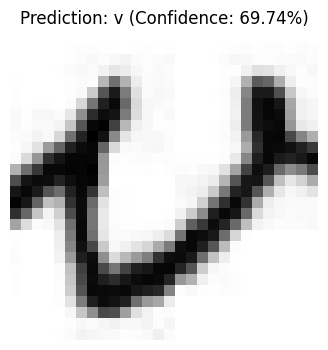

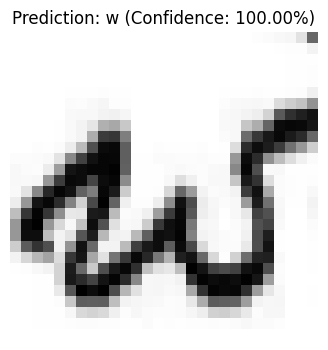

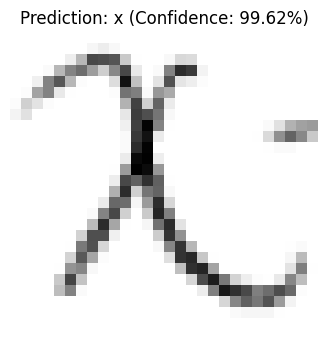

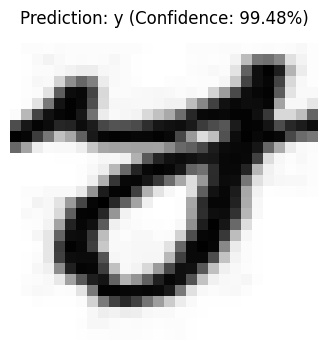

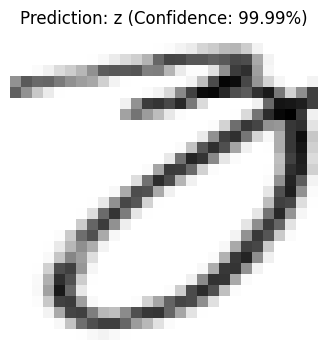

In [10]:
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

model_path = 'handwritten_alphabet_recognition_model.h5'
model = load_model(model_path)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

label_encoder = LabelEncoder()
label_encoder.fit([chr(i) for i in range(ord('a'), ord('z') + 1)])  # Fit on 'a' to 'z'

def preprocess_image(img_path, size=(28, 28)):
    try:
        img = Image.open(img_path).convert('L').resize(size, Image.Resampling.LANCZOS)
        img_array = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, axis=(0, -1))
        return img_array
    except (IOError, ValueError) as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

def get_class_label(idx):
    return label_encoder.inverse_transform([idx])[0]  # Convert index back to character

folder = "Testing_Samples/"

for char in range(ord('a'), ord('z') + 1):
    img_path = os.path.join(folder, f"{chr(char)}.png")
    if os.path.exists(img_path):  
        input_image = preprocess_image(img_path)
        if input_image is not None:  
            prediction = model.predict(input_image, verbose=0)
            predicted_label_idx = np.argmax(prediction)
            predicted_label = get_class_label(predicted_label_idx)
            confidence = prediction[0][predicted_label_idx] * 100

            plt.figure(figsize=(4, 4))
            plt.imshow(np.squeeze(input_image), cmap='gray')  # Remove batch/channel dims
            plt.title(f"Prediction: {predicted_label} (Confidence: {confidence:.2f}%)")
            plt.grid(False)
            plt.axis('off')  # Hide axes for cleaner look
            plt.show()
    else:
        print(f"Image not found: {img_path}")

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load trained model
model_path = 'handwritten_alphabet_recognition_model.h5'
model = load_model(model_path)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

label_encoder = LabelEncoder()
label_encoder.fit([chr(i) for i in range(ord('a'), ord('z') + 1)]) 

# Function to preprocess the image
def preprocess_image(img_path, size=(28, 28)):
    try:
        img = Image.open(img_path).convert('L').resize(size, Image.Resampling.LANCZOS)
        img_array = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, axis=(0, -1))
        return img_array
    except (IOError, ValueError) as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

image_path = 'g.jpg'

input_image = preprocess_image(image_path)

if input_image is not None: 

    prediction = model.predict(input_image, verbose=0)
    predicted_label_idx = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
    confidence = prediction[0][predicted_label_idx] * 100

    # Visualize the input image and prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(np.squeeze(input_image), cmap='gray') 
    plt.title(f"Prediction: {predicted_label} (Confidence: {confidence:.2f}%)")
    plt.grid(False)
    plt.show()
else:
    print(f"Failed to load or preprocess image: {image_path}")

In [ ]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input Layer
inputs = Input(shape=(28, 28, 1))

# First Conv Block
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

# Second Conv Block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and Fully Connected Layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Create Model
baseline_model = Model(inputs=inputs, outputs=outputs)

# Compile Model with RMSprop Optimizer
optimizer = Adam(learning_rate=0.001)
baseline_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Baseline Model
baseline_history = baseline_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Save Model
baseline_model.save('functional_baseline_model.h5')